# PS2: Selection of a Tangent Portfolio and Your Asset Allocation
The objective of `PS2` is to walk you through the calculation of your position on the capital allocation line that considers your risk aversion. This problem set is based on the `L5b` capital allocation example notebook, which is available on the [CHEME 5760 example repository](https://github.com/varnerlab/CHEME-5760-Examples-F23.git). 

#### Problem statement
In `PS2`, we'll start by constructing the return and covariance for a set of stocks you choose, and then we’ll work our way to calculate your optimal value of $\theta$, i.e., your location on the capital allocation line. In particular, we'll do these tasks:
* Task 1: Compute the log return array and covariance matrix for a collection of `N = 10` stocks that you select from the historical dataset 
* Task 2: Compute the efficient frontier for your collection of `N = 10` stocks
* Task 3: Compute the capital allocation line connecting the risk-free asset and the tangent portfolio
* Task 4: Use your estimated value for the risk aversion parameter `A` to calculate your investment allocation along the capital allocation line

## Setup
The computations in this lab (or example) are enabled by the [VLDecisionsPackage.jl](https://github.com/varnerlab/VLDecisionsPackage.jl.git) and several external `Julia` packages. To load the required packages and any custom codes the teaching team has developed to work with these packages, we [include](https://docs.julialang.org/en/v1/manual/code-loading/) the `Include.jl` file):

In [1]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLDecisionsPackage.jl.git`
    Updating registry at `C:\Users\Lillian K\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\Lillian K\OneDrive\Documents\5760PS2\CHEME-5760-PS2-AssetSelectionProblem-Fall-2023\Project.toml`
  No Changes to `C:\Users\Lillian K\OneDrive\Documents\5760PS2\CHEME-5760-PS2-AssetSelectionProblem-Fall-2023\Manifest.toml`
Precompiling project...
  ✓ QuadGK
  ✓ Distributions
  ✓ VLDecisionsPackage
  3 dependencies successfully precompiled in 356 seconds. 217 already precompiled.
  Activating project at `C:\Users\Lillian K\OneDrive\Documents\5760PS2\CHEME-5760-PS2-AssetSelectionProblem-Fall-2023`
    Updating registry at `C:\Users\Lillian K\.julia\registries\General.toml`
    Updating git-repo `https://github.com/varnerlab/VLDecisionsPackage.jl.git`
   Installed XML2_jll ────── v2.11.5+0
   Installed GLPK ────────── v1.1.3
   Installed Distributions ─ v0.25.102
    Updating `

### Packages
`Include.jl` loads several external packages that we will use for our excercise:
* [DataFrames.jl](https://dataframes.juliadata.org/stable/) provides a set of tools for working with tabular data in [Julia](https://julialang.org). Its design and functionality are similar to those of [Pandas (in Python)](https://pandas.pydata.org) and [data.frame, data.table and dplyr (in R)](https://dplyr.tidyverse.org), making it a great general purpose data science tool.
* [Plots.jl](https://docs.juliaplots.org/stable/) is a plotting library in [Julia](https://julialang.org). [Plots.jl](https://docs.juliaplots.org/stable/) exports the `plot(...)` function which we use to visualize data.
* [VLDecisionsPackage.jl](https://github.com/varnerlab/VLDecisionsPackage.jl.git) holds the codes and types for most of the computation used in the problem set.

### Types
The `MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem` type, which encodes data required to compute the efficient frontier for a collection of $N$ risky assets only, has the fields:
* `Σ::Array{Float64,2}` is the $N\times{N}$ covariance matrix, with entries $cov(r_{i},r_{j})$
* `μ::Array{Float64,1}` is the $N\times{1}$ vector of expected return values with elements $\mathbb{E}(r_{i})$
* `bounds::Array{Float64,2}` is an $N\times{2}$ array that holds the upper and lower bound for the asset allocation. Each row corresponds to an asset, while the first column is the lower bound, and the second column is the upper bound on the asset allocation fraction.
* `R::Float64` denotes the lower bound on the desired return
* `initial::Array{Float64,1}` is the $N\times{1}$ array of initial guesses

The `MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem`, which encodes data required to compute the optimal allocation for a portfolio containing $N$ risky assets and a single risk-free asset, has the fields:
* `Σ::Array{Float64,2}` is the $N\times{N}$ covariance matrix, with entries $cov(r_{i},r_{j})$
* `μ::Array{Float64,1}` is the $N\times{1}$ vector of expected return values, with elements $\mathbb{E}(r_{i})$
* `bounds::Array{Float64,2}` is an $N\times{2}$ array that holds the upper and lower bound for the asset allocation. Each row corresponds to an asset, while the first column is the lower bound, and the second column is the upper bound on the asset allocation fraction.
* `R::Float64` denotes the lower bound on the desired return
* `initial::Array{Float64,1}` is the $N\times{1}$ array of initial guesses
* `risk_free_rate::Float64` is the risk-free rate of return, e.g., the rate of return on a [10-year US Treasury Note](https://www.cnbc.com/bonds/)

#### Functions
* The `MyPortfolioDataSet()` function loads the risky asset price dataset, and returns it as a [DataFrame.jl](https://dataframes.juliadata.org/stable/) instance. 
* The ` MyFirmMappingDataSet()` function load the firm mapping, and returns it as a [DataFrame.jl](https://dataframes.juliadata.org/stable/) instance.
* The `build(...)` is a factory method that takes the type of object that you wish to construct, and the parameters required to construct the object, e.g., the fields of the `MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem` or `MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem` types.
* The `solve(...)` method takes a `problem` type, e.g., an instance of `MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem` and returns the solution to the problem as a [Julia Dictionary](https://docs.julialang.org/en/v1/base/collections/#Dictionaries) instance.

### Load historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) for the past five-trading years (a maximum of `1256` data points per firm). However, not all the firms in the `dataset` have the maximum number of trading days, i.e., some firms are missing information for various reasons; perhaps they were acquired, merged, or delisted, etc. We will exclude these firms from the `dataset`.

We load the price `dataset` by calling the `MyPortfolioDataSet()` function:

In [2]:
dataset = MyPortfolioDataSet() |> x-> x["dataset"];

The all keys array holds the list of firm indexes in the dataset that have complete data, i.e., all `1256` data values: 

In [3]:
all_firms = keys(dataset) |> collect |> sort;

However, while it is sometimes convenient to work with the data using the `firm_index`, often we specify the [ticker symbol](https://en.wikipedia.org/wiki/Ticker_symbol#:~:text=A%20ticker%20symbol%20or%20stock,on%20a%20particular%20stock%20market.) instead. To facilitate this, let's load a mapping between the `firm_index` and the ticker symbols using the `MyFirmMappingDataSet()` function. We store this mapping in the `firm_mapping_df` variable, which is of type `DataFrame`:

In [4]:
firm_mapping_df = MyFirmMappingDataSet()

Row,Symbol,Name,Sector
,String7,String,String31
1,MMM,3M,Industrials
2,AOS,A. O. Smith,Industrials
3,ABT,Abbott Laboratories,Health Care
4,ABBV,AbbVie,Health Care
5,ABMD,Abiomed,Health Care
6,ACN,Accenture,Information Technology
7,ATVI,Activision Blizzard,Communication Services
8,ADM,ADM,Consumer Staples
9,ADBE,Adobe,Information Technology


To interconvert between the `firm_index` and `ticker` representation of the firms in the dataset, we create a `ticker_lookup_dictionary` which holds the ticker symbols as the keys and the `firm_index` as the value:

In [6]:
ticker_lookup_dictionary = Dict{String,Int64}();
number_of_map_elements = nrow(firm_mapping_df);
for i ∈ 1:number_of_map_elements
    ticker = firm_mapping_df[i,:Symbol];    
    ticker_lookup_dictionary[ticker] = i;
end

For example, [Apple](https://www.apple.com) has the `ticker = AAPL`, in the dataset that is `firm_index`:

In [15]:
ticker_lookup_dictionary["AAPL"]

function correlation(Σ, firm_id1, firm_id2)
    # Extract the covariance values for the two firms from the covariance matrix Σ
    cov_xy = Σ[firm_id1, firm_id2]
    cov_x = Σ[firm_id1, firm_id1]
    cov_y = Σ[firm_id2, firm_id2]
    
    # Calculate the correlation
    correlation_value = cov_xy / sqrt(cov_x * cov_y)
    
    return correlation_value
end

correlation (generic function with 1 method)

### Compute the covariance and expected yield for all firms in the dataset
The expected return $\mathbb{E}(r_{i})$ and covariance matrix $\Sigma$ will be used in your calculations, so we'll provide values for both of these items for the entire data set (all `N = 458` companies), and then you can pick out which forms you are interested in. 

First, we compute the expected (annualized) log return by passing the `dataset` and the entire list of firms we have in the dataset (held in the $N\times{1}$ `all_firms` array) to the `log_return_matrix(...)` method. The result is stored in the `all_firms_return_matrix` variable, a $T-1\times{N}$ array of log return values. Each row of `all_firms_return_matrix` corresponds to a time-value, while each column corresponds to a firm:

In [8]:
all_firms_return_matrix = log_return_matrix(dataset, all_firms; Δt = (1/252));

Next, we estimate the `covariance_matrix` from the `all_firms_return_matrix` using the `cov(...)` function, which is exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We store the $N\times{N}$ covariance matrix in the $\Sigma$ variable:

In [13]:
Σ = cov(all_firms_return_matrix) |> x-> x*(1/100);
Σ

458×458 Matrix{Float64}:
 0.143734   0.0885069  0.059015   …  0.0810422  0.101054    0.0606202
 0.0885069  0.17848    0.0568238     0.0769141  0.109112    0.0632871
 0.059015   0.0568238  0.133729      0.0744477  0.0515959   0.0855697
 0.0543542  0.04277    0.0618499     0.0752029  0.0614497   0.0671
 0.0804019  0.0807385  0.0820575     0.103932   0.104342    0.100788
 0.0282115  0.034607   0.0487898  …  0.03281    0.00702594  0.0468175
 0.0667121  0.0630362  0.0439656     0.0812056  0.110726    0.0501026
 0.0558546  0.0656366  0.0849889     0.091549   0.0513129   0.107614
 0.0724133  0.082889   0.0474096     0.0926652  0.106733    0.0783041
 0.0877197  0.0937396  0.102236      0.119016   0.0968968   0.11481
 0.0715101  0.082505   0.0551011  …  0.130621   0.128317    0.0829613
 0.0847542  0.0827172  0.0550736     0.128302   0.15409     0.0784002
 0.067686   0.0751399  0.0882169     0.0924965  0.0823665   0.0974956
 ⋮                                ⋱  ⋮                      
 0.114902  

Finally, we estimate the expected return for each firm from the `all_firms_return_matrix` using the `mean(...)` function, which is exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We set the $N\times{1}$ vector of expected values, i.e., $\mathbb{E}(r_{1}),\dotsc,\mathbb{E}(r_{N})$ in the variable $\mu$:

In [10]:
μ = mean(all_firms_return_matrix, dims=1) |> vec |> x-> exp.(x) .- 1;

### Set constants used in the calculations
Lastly, we set some constant values that are used in the computation of the efficient frontier and the capital allocation line:

In [11]:
number_of_firms = 10;
initial = zeros(number_of_firms);
initial[1] = 1.0;
bounds = zeros(number_of_firms,2);
bounds[:,2] .= 1.0;
risk_free_rate = exp(0.045) - 1;
number_of_points = 20;

## Task 1: Build the log return array and covariance matrix for your tangent portfolio $\mathcal{T}$
Before we compute the fraction of risky versus risk-free assets in the complete portfolio, we must decide which stocks to include in the risky portfolio. One strategy is to pick stocks that have small or even negative covariance. Let's explore this idea. 

Specify five `ticker symbols`, e.g., `AAPL`, `MSFT`, etc., that interest you in the `my_list_of_tickers` array. We'll  put the indexes of your five firms in the `my_list_of_firm_ids` array:

In [18]:
# Add your tickers to the my_list_of_tickers array
my_list_of_tickers = ["ADBE","ACN","AAPL","ADM","AAP"];
my_list_of_firm_ids = Array{Int64,1}();
for ticker ∈ my_list_of_tickers
    firm_index = ticker_lookup_dictionary[ticker];    
    push!(my_list_of_firm_ids, firm_index)
end
my_list_of_firm_ids

5-element Vector{Int64}:
  9
  6
 46
  8
 10

Next, for each the firms you selected, _find the lowest correlation twin firm_ by analyzing the entries of the covariance matrix. Add the indexes of these twin firms to the `my_list_of_firm_ids` array using the `push!(...)` function:

In [20]:
lowest_corr_twin = Array{Int64, 1}()
min_corr_values = zeros(length(my_list_of_tickers))
for (index, firm_id) in enumerate(my_list_of_firm_ids)
    correlations = [correlation(Σ, firm_id, other_firm_id) for other_firm_id in 1:number_of_firms]
    min_corr_index = argmin(correlations)  # Find the index with the minimum correlation
    push!(lowest_corr_twin, min_corr_index)
    min_corr_values[index] = minimum(correlations)
end
for twin_index in lowest_corr_twin
    push!(my_list_of_firm_ids, twin_index)
end

Now that you have selected the firms in your risky portfolio, we'll compute for you the firm-specific expected return vector and covariance matrix. We'll store these in the $\hat{\mu}$ and $\hat{\Sigma}$ variables. First, we'll construct the $\hat{\mu}$ vector:

In [21]:
my_list_of_firm_ids

10-element Vector{Int64}:
  9
  6
 46
  8
 10
  6
  9
  6
  7
  4

In [22]:
# --- DO NOT CHANGE THIS BLOCK ----------------------------------------- #
μ̂ = Array{Float64,1}();
for i ∈ eachindex(my_list_of_firm_ids)
    firm_index = findfirst(x->x==my_list_of_firm_ids[i], all_firms)
    push!(μ̂, μ[firm_index])
end
# ---------------------------------------------------------------------- #

and then we'll compute the covariance $\hat{\Sigma}$ matrix:

In [23]:
# --- DO NOT CHANGE THIS BLOCK ----------------------------------------- #
my_number_of_selected_firms = length(my_list_of_firm_ids)
Σ̂ = Array{Float64,2}(undef, my_number_of_selected_firms, my_number_of_selected_firms);
for i ∈ eachindex(my_list_of_firm_ids)
    row_firm_index = findfirst(x->x==my_list_of_firm_ids[i], all_firms)
    for j ∈ eachindex(my_list_of_firm_ids)
        col_firm_index = findfirst(x->x==my_list_of_firm_ids[j], all_firms)
        Σ̂[i,j] = Σ[row_firm_index, col_firm_index]
    end
end
# ---------------------------------------------------------------------- #

## Task 2: Compute the efficient frontier for your collection of `N = 10` stocks
Create an instance of the `MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem` type, and store this in the `problem_risk` variable using the `build(...)` method. You'll need to pass your covariance array $\hat{\Sigma}$, the expected return array $\hat{\mu}$, along with bounds and an initial guess, to the `build(...)` method:

In [38]:
# Build a problem object using the build method
# Define the bounds and initial guess
number_of_firms = length(all_firms);
initial = zeros(number_of_firms);
initial[1] = 1.0;
bounds = zeros(number_of_firms,2);
bounds[:,2] .= 1.0;
risk_free_rate = 0.045
number_of_points = 20;
# Create an instance of the MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem
problem_risk = build(MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem, (
    Σ = Σ,
    μ = μ,
    bounds = bounds,
    initial = initial,
    R = 0.0
));

Next, we'll create an array with the minimum desired rewards (the calculation must achieve at least this much reward) by starting at the `risk_free_rate`, and stepping to 10$\times$`risk_free_rate`. Store these values in the `minimum_desired_reward_array` variable:

In [30]:
minimum_desired_reward_array = range(risk_free_rate, stop = 10*risk_free_rate, length = number_of_points) |> collect;

Finally, we iterate through the `minimum_desired_reward_array` and compute the minimum risk required to achieve the specified reward level using a `for-loop`. In particular, for each pass through the loop, we:
* Update the `problem_risk` variable with the minimum desired reward
* We then pass the updated `problem_risk` object to the `solve(...)` method (which initializes and solves the optimization problem). The solution returned from the `solve(...)` method is stored in the `solution` dictionary. 
* We check the `status` of the solution. If the `status` indicates an optimal solution was found, we store the solution in the `efficient_frontier` dictionary.

In [39]:
efficient_frontier = Dict{Float64,Float64}();
for i ∈ eachindex(minimum_desired_reward_array)
    
    # update the problem object -
    problem_risk.R = minimum_desired_reward_array[i];
    
    # compute -
    solution = solve(problem_risk)

    # check: did this converge?
    status_flag = solution["status"];    
    if (status_flag == MathOptInterface.LOCALLY_SOLVED)
        key = sqrt(solution["objective_value"]);
        value = solution["reward"];
        efficient_frontier[key] = value;
    end
end


## Task 3: Compute the CAL for your collection of `N = 10` stocks and a risk-free asset
To compute the capital allocation line, create an instance of the `MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem` type, and store this in the `problem_risk_free` variable using the `build(...)` method. You'll need to pass your covariance array $\hat{\Sigma}$, the expected return array $\hat{\mu}$, along with bounds, an initial guess, and the risk-free rate to the `build(...)` method:

In [41]:
problem_risk_free = build(MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem, (
    Σ = Σ,
    μ = μ,
    bounds = bounds,
    initial = initial,
    risk_free_rate = risk_free_rate,
    R = 0.0
));

Iterate through the `minimum_desired_reward_array` and compute the minimum risk required to achieve the specified reward level, in the presence of a risk-free asset, using a `for-loop`. In particular, for each pass through the loop, we:
* Update the `problem_risk_free` variable with the minimum desired reward
* We then pass the updated `problem_risk_free` object to the `solve(...)` method (which initializes and solves the optimization problem). The solution returned from the `solve(...)` method is stored in the `solution_risk_free` dictionary. 
* We check the `status` of the solution. If the `status` indicates an optimal solution was found, we store the solution in the `capital_allocation_line` dictionary.

In [42]:
capital_allocation_line = Dict{Float64,Float64}();
for i ∈ eachindex(minimum_desired_reward_array)
    
    # update the problem object -
    problem_risk_free.R = minimum_desired_reward_array[i];
    
    # compute -
    solution_risk_free = solve(problem_risk_free)

    # check: did this converge?
    status_flag = solution_risk_free["status"];    
    if (status_flag == MathOptInterface.LOCALLY_SOLVED)
        key = sqrt(solution_risk_free["objective_value"]);
        value = solution_risk_free["reward"];
        capital_allocation_line[key] = value;
    end
end
capital_allocation_line;

### Estimate the risk and reward for the tangent portfolio
Plot the efficient frontier and the capital allocation line on the $\sigma$ (risk) versus $\mathbb{E}(r)$ (reward) plane. Estimate the return and risk of the tangent portfolio from the graph:  

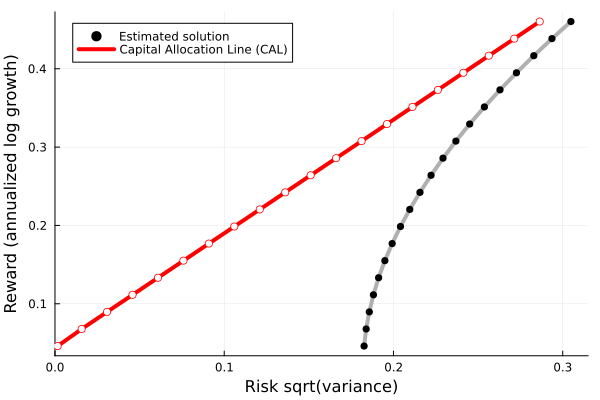

In [43]:
# uncomment the block below and execute. If all is working, you should see the efficient frontier and the capital allocation line

# plot the efficient frontier 
plot(efficient_frontier, lw=4, xlabel="Risk sqrt(variance)", 
    ylabel="Reward (log return)", fontsize=18, label="", c=:gray69, 
    xlim=(0.0, 1.1*maximum(efficient_frontier).first))
scatter!(efficient_frontier, label="Estimated solution", c=:black)

# plot the capital allocation line
plot!(capital_allocation_line, lw=4, xlabel="Risk sqrt(variance)", 
    ylabel="Reward (annualized log growth)", fontsize=18, c=:red, 
    xlim=(0.0, 1.1*maximum(capital_allocation_line).first), label="Capital Allocation Line (CAL)")
scatter!(capital_allocation_line, label="", msc=:red, mc=:white)

## Task 4: Compute your operating point on the CAL
Now that we have the values for the tangent portfolio, we can estimate where we lie on the capital allocation line that considers our risk aversion, i.e., how we feel about taking risks. First, specify your risk aversion parameter `A`:
* Large values of `A` imply the decision maker is risk-averse
* Small values of `A` suggest the decision maker is less concerned with risk

In [44]:
A = 10; # update this with the value we estimated for you from lecture 

Next, set the values of the tangent portfolio and resolve the problem. In particular, update the `R` field of the `problem_risk_free` model with the value of the return for the tangent portfolio that you estimated from the graph, and then solve the optimization problem again using the `solve(...)` function passing in the updated risk-free model. Store the tangent portfolio solution in the `solution_tangent_portfolio` variable:

In [50]:
problem_risk_free.R = 0.1;
solution_tangent_portfolio = solve(problem_risk_free)

Dict{String, Any} with 4 entries:
  "argmax"          => [1.26968e-7, 1.77819e-7, 3.32046e-7, 3.54078e-7, 2.07676…
  "reward"          => 0.1
  "status"          => LOCALLY_SOLVED
  "objective_value" => 0.00143992

Finally, compute you optimal $\hat{\theta}$ value using the analytical solution of the utility maximization problem and your `A`

In [55]:
variance = solution_tangent_portfolio["objective_value"]
θ̂ = (problem_risk_free.R - risk_free_rate)/(A*variance);
risk_value = θ̂*sqrt(variance);
reward_value = θ̂*(problem_risk_free.R)+(1-θ̂)*problem_risk_free.risk_free_rate;
θ̂ 

3.819664121011346

In [56]:
risk_value

0.14494189410092034

In [57]:
reward_value

0.255081526655624

### What does your $\hat{\theta}$ mean?
theta represents the weight assigned to the risky assets in the portfolio. It indicates the proportion of the portfolio's value that should be invested in risky assets as opposed to risk-free assets. Ideally, the value of θ̂  found should be the one that maximizes expected return while considering the risks. 

## Disclaimer and Risks

__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team.

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.